In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import train_test_split

df = pd.read_csv("dataframes/final_df.csv")
df.head()

,id,lat,lon,date,severity,borough_Barking and Dagenham,borough_Barnet,borough_Bexley,borough_Brent,borough_Bromley,...,borough_Southwark,borough_Sutton,borough_Tower Hamlets,borough_Waltham Forest,borough_Wandsworth,casualty_age_0-23,casualty_age_24-30,casualty_age_31-38,casualty_age_39-50,casualty_age_50+
0,345906,51.511963,-0.028211,2019-01-03 01:20:00+00:00,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
1,345907,51.371636,-0.117621,2019-01-02 22:45:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,345908,51.514951,-0.072747,2019-01-02 18:45:00+00:00,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,345909,51.519173,-0.262356,2019-01-03 08:41:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,345910,51.565743,-0.136308,2019-01-03 08:37:00+00:00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
X = df.drop(columns=['severity', 'id', 'date'])
y = df['severity']  # Assicurati che sia numerico o mappato (1, 2, 3)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(40500, 40)
(10126, 40)
(40500,)
(10126,)


In [5]:
random_state=42

sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

model = XGBClassifier(random_state=random_state)
model.fit(X_train, y_train, sample_weight=sample_weights)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

              precision    recall  f1-score   support

           0      0.916     0.760     0.831      8614
           1      0.302     0.590     0.400      1470
           2      0.286     0.762     0.416        42

    accuracy                          0.735     10126
   macro avg      0.501     0.704     0.549     10126
weighted avg      0.824     0.735     0.766     10126



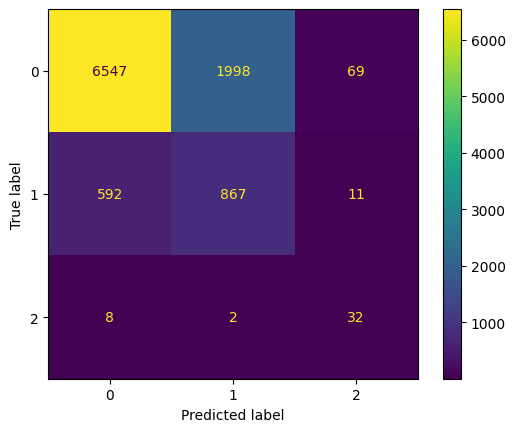

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, digits=3))

cm=confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm)

disp.plot()
plt.show()

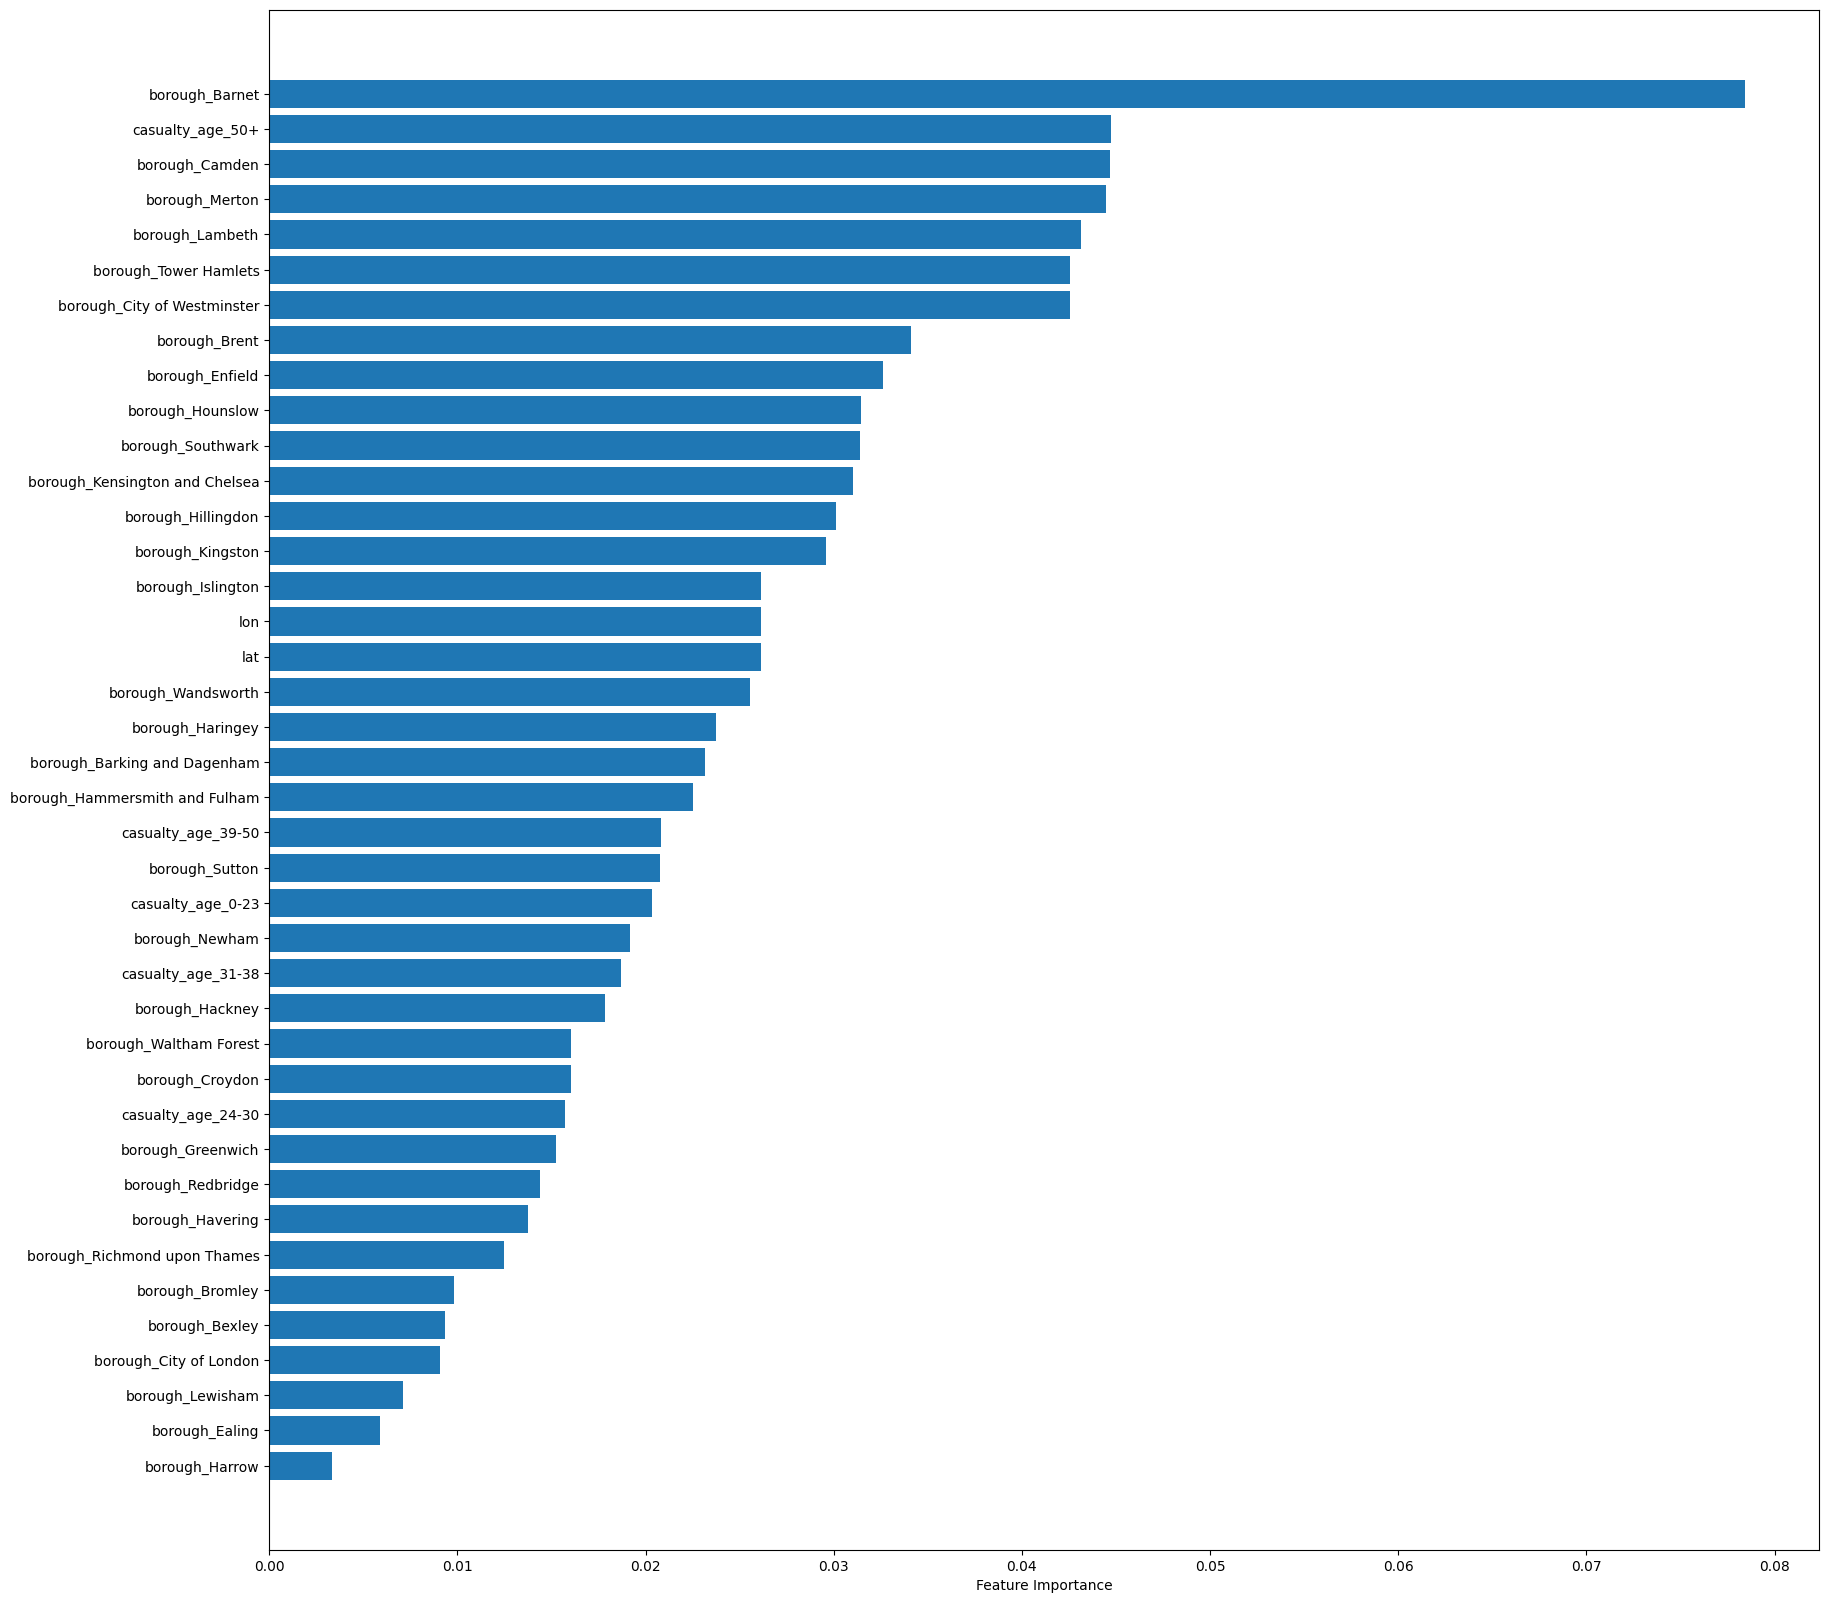

In [8]:
feature_importance = model.feature_importances_
plt.figure(figsize=(20,20))
sorted_idx = np.argsort(feature_importance)
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

In [9]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_sample_weight
import numpy as np
import pandas as pd

X = df.drop(columns=['severity', 'id', 'date'])
y = df['severity']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

adasyn = ADASYN(random_state=42)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

sample_weights = compute_sample_weight(class_weight='balanced', y=y_res)

param_grid = {
    'learning_rate': [ 0.2,0.3],
    'max_depth': [  9,11],
    'subsample': [  1.0,1.2],
    # 'colsample_bytree': [0.6, 0.8, 1.0],
    # 'n_estimators': [100, 200, 300],
    # 'gamma': [0, 0.1, 0.2],
    # 'reg_alpha': [0.0, 0.1, 1.0],
    # 'reg_lambda': [1.0, 1.5, 2.0],
}

xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42,
    n_jobs=-1
)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1_macro',  
    cv=3,                
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_res, y_res, sample_weight=sample_weights)

print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

model_xgb_adysin = grid_search.best_estimator_


Fitting 3 folds for each of 8 candidates, totalling 24 fits


c:\Users\AaronSalazar\Desktop\Bolo\ai_industry\.venv\lib\site-packages\sklearn\model_selection\_validation.py:542: FitFailedWarning: 
12 fits failed out of a total of 24.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\AaronSalazar\Desktop\Bolo\ai_industry\.venv\lib\site-packages\sklearn\model_selection\_validation.py", line 890, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\AaronSalazar\Desktop\Bolo\ai_industry\.venv\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "c:\Users\AaronSalazar\Desktop\Bolo\ai_industry\.venv\lib\site-packages\xgboost\sklearn.py", line 1490,


Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 1.0}
Best F1 Score: 0.8030183203400982



Classification Report:
              precision    recall  f1-score   support

      Slight      0.943     0.795     0.863      8613
     Serious      0.396     0.713     0.509      1465
       Fatal      0.114     0.542     0.188        48

    accuracy                          0.782     10126
   macro avg      0.484     0.683     0.520     10126
weighted avg      0.860     0.782     0.808     10126



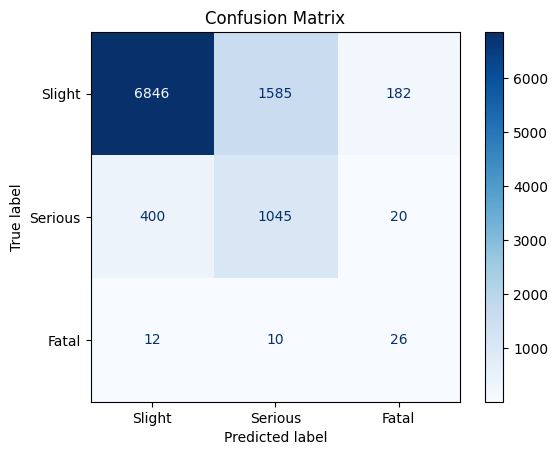

In [10]:
y_pred = model_xgb_adysin.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Slight', 'Serious', 'Fatal'], digits=3))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Slight', 'Serious', 'Fatal'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [11]:
from sklearn.metrics import roc_auc_score

xbm_score_cv = grid_search.best_score_  
y_proba      = model_xgb_adysin.predict_proba(X_test)
xbm_score_test = roc_auc_score(y_test, y_proba, multi_class='ovr')
xbm_params     = grid_search.best_params_

print(f'AUC score for {xbm_params}: {xbm_score_cv:.2f} (cross-val.), {xbm_score_test:.2f} (test)')

AUC score for {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 1.0}: 0.80 (cross-val.), 0.84 (test)


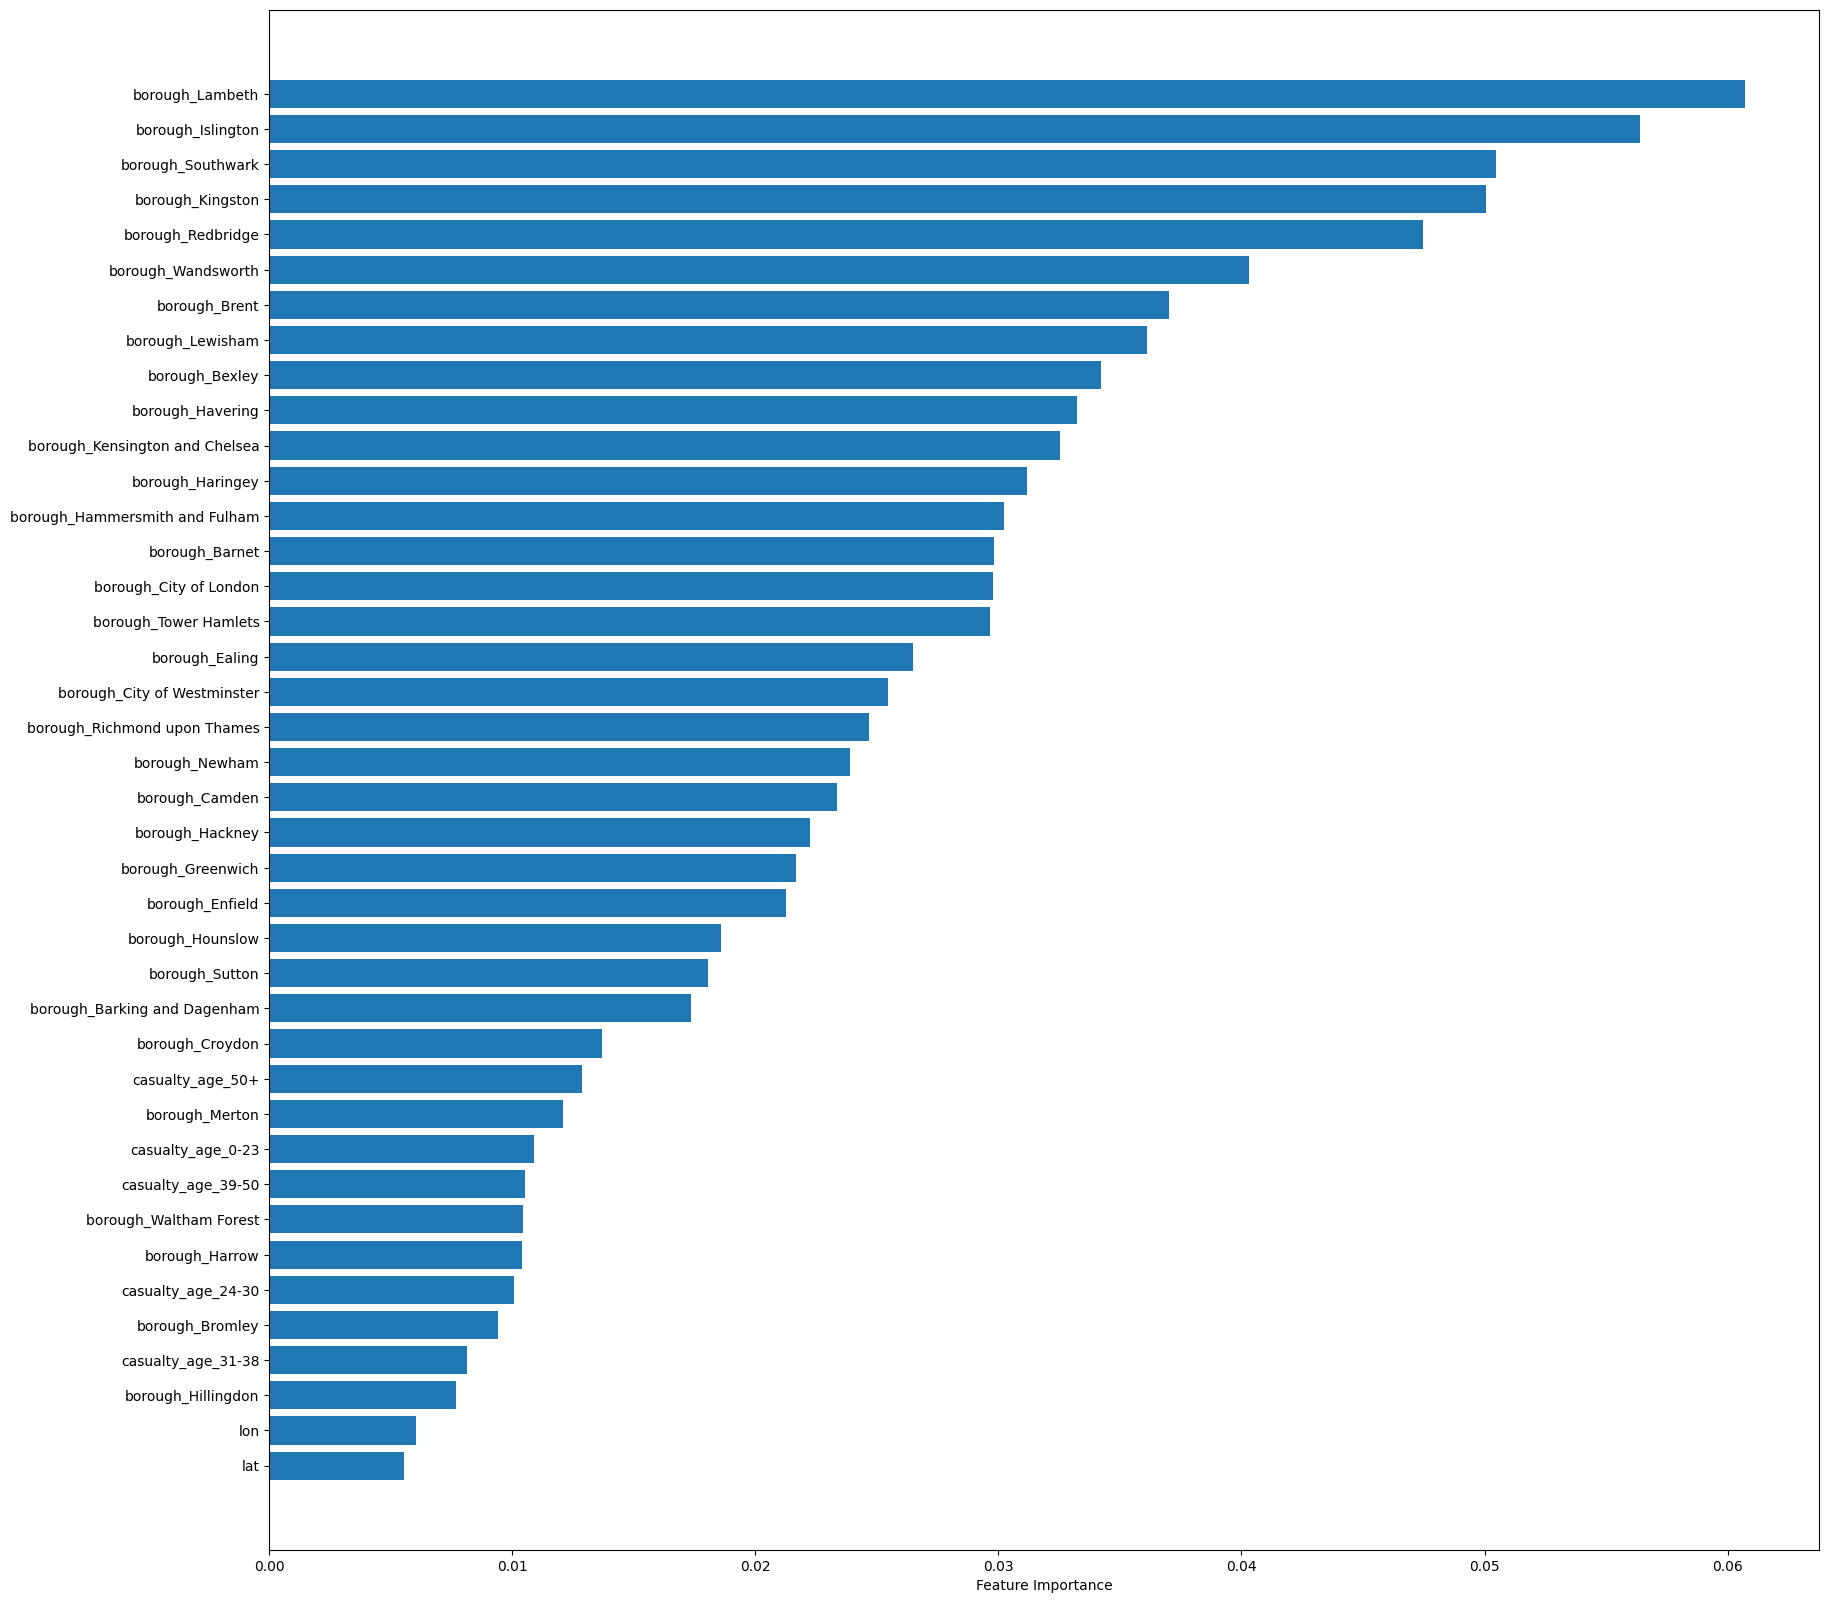

In [12]:
feature_importance = model_xgb_adysin.feature_importances_
plt.figure(figsize=(20,20))
sorted_idx = np.argsort(feature_importance)
plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

In [13]:
from sklearn.inspection import permutation_importance

r_train = permutation_importance(model, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

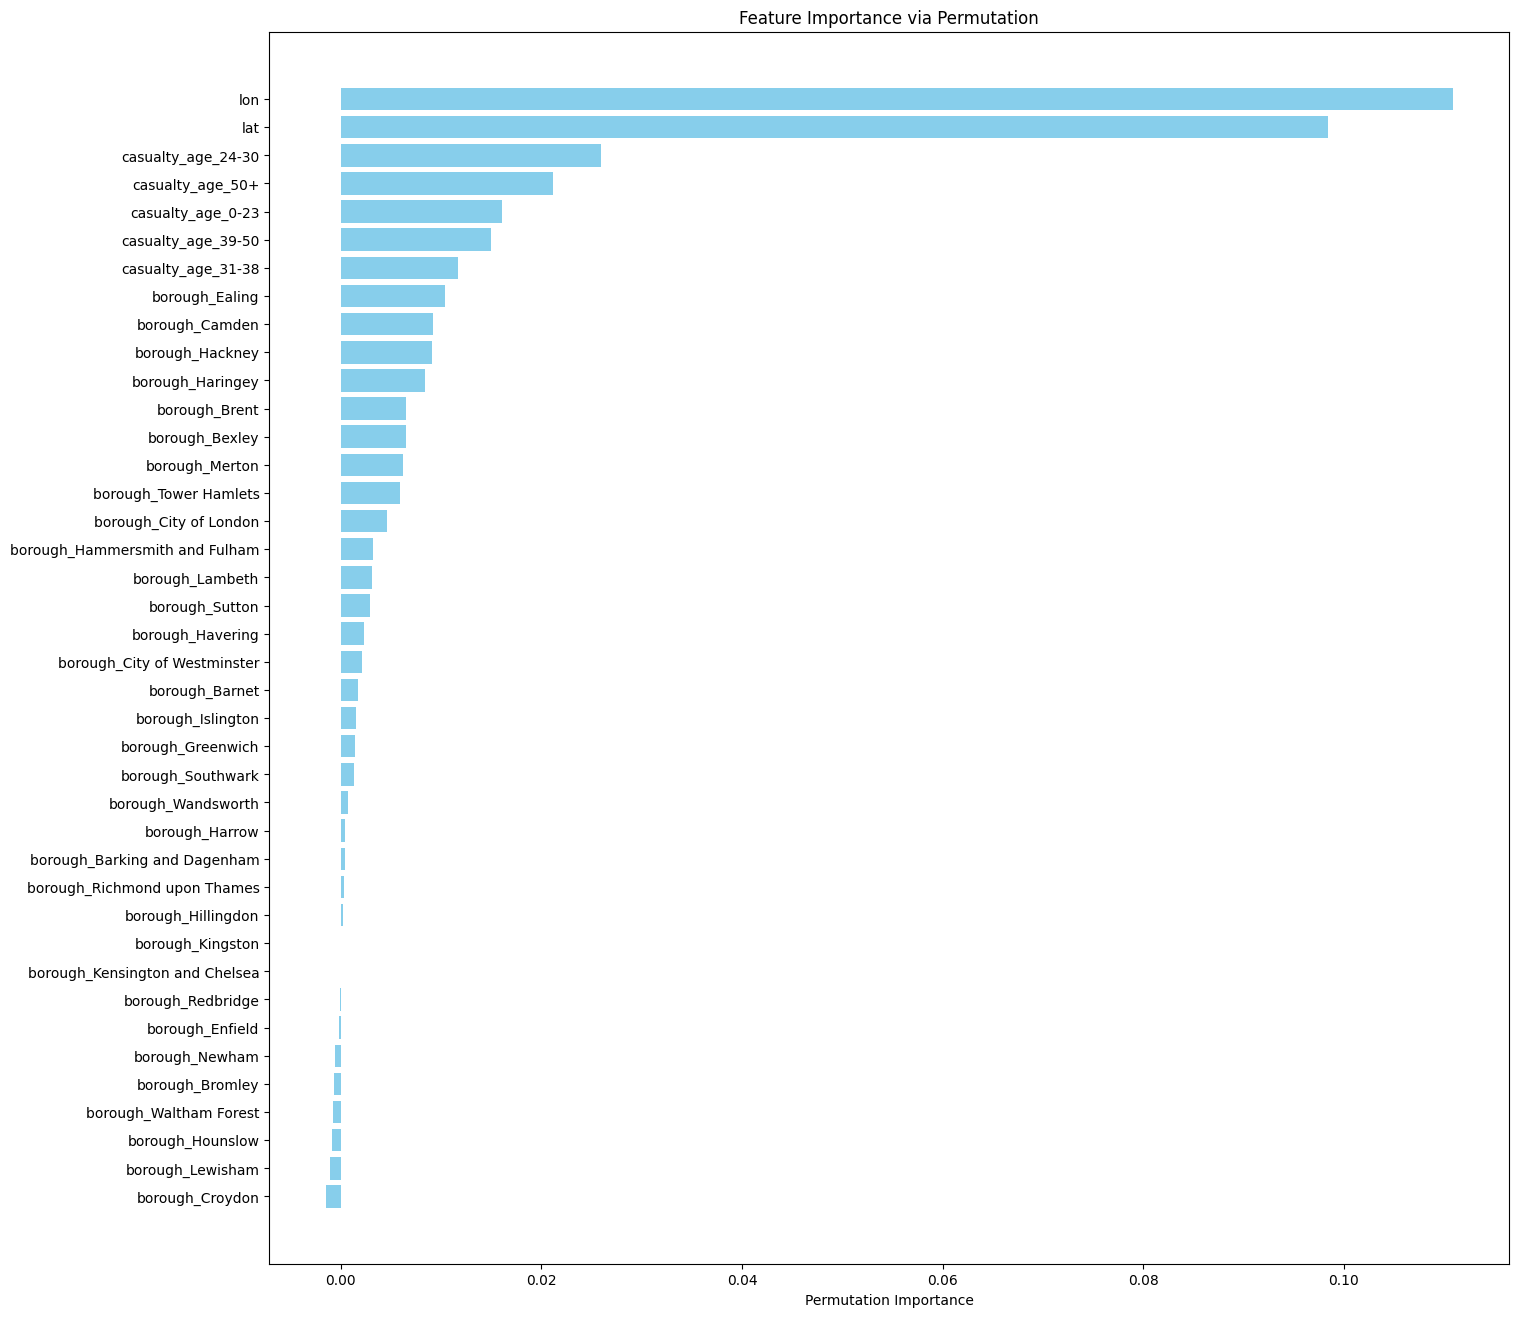

In [14]:
sorted_idx = r_train.importances_mean.argsort()

plt.figure(figsize=(16, 16))
plt.barh(X_train.columns[sorted_idx], r_train.importances_mean[sorted_idx], color="skyblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.show()

### Model XGB With Adysin in permutation

In [15]:
from sklearn.inspection import permutation_importance

r_train = permutation_importance(model_xgb_adysin, X_train, y_train, n_repeats=30, random_state=42)
xbm_p_imp = pd.Series(index=X.columns, data=r_train.importances_mean)

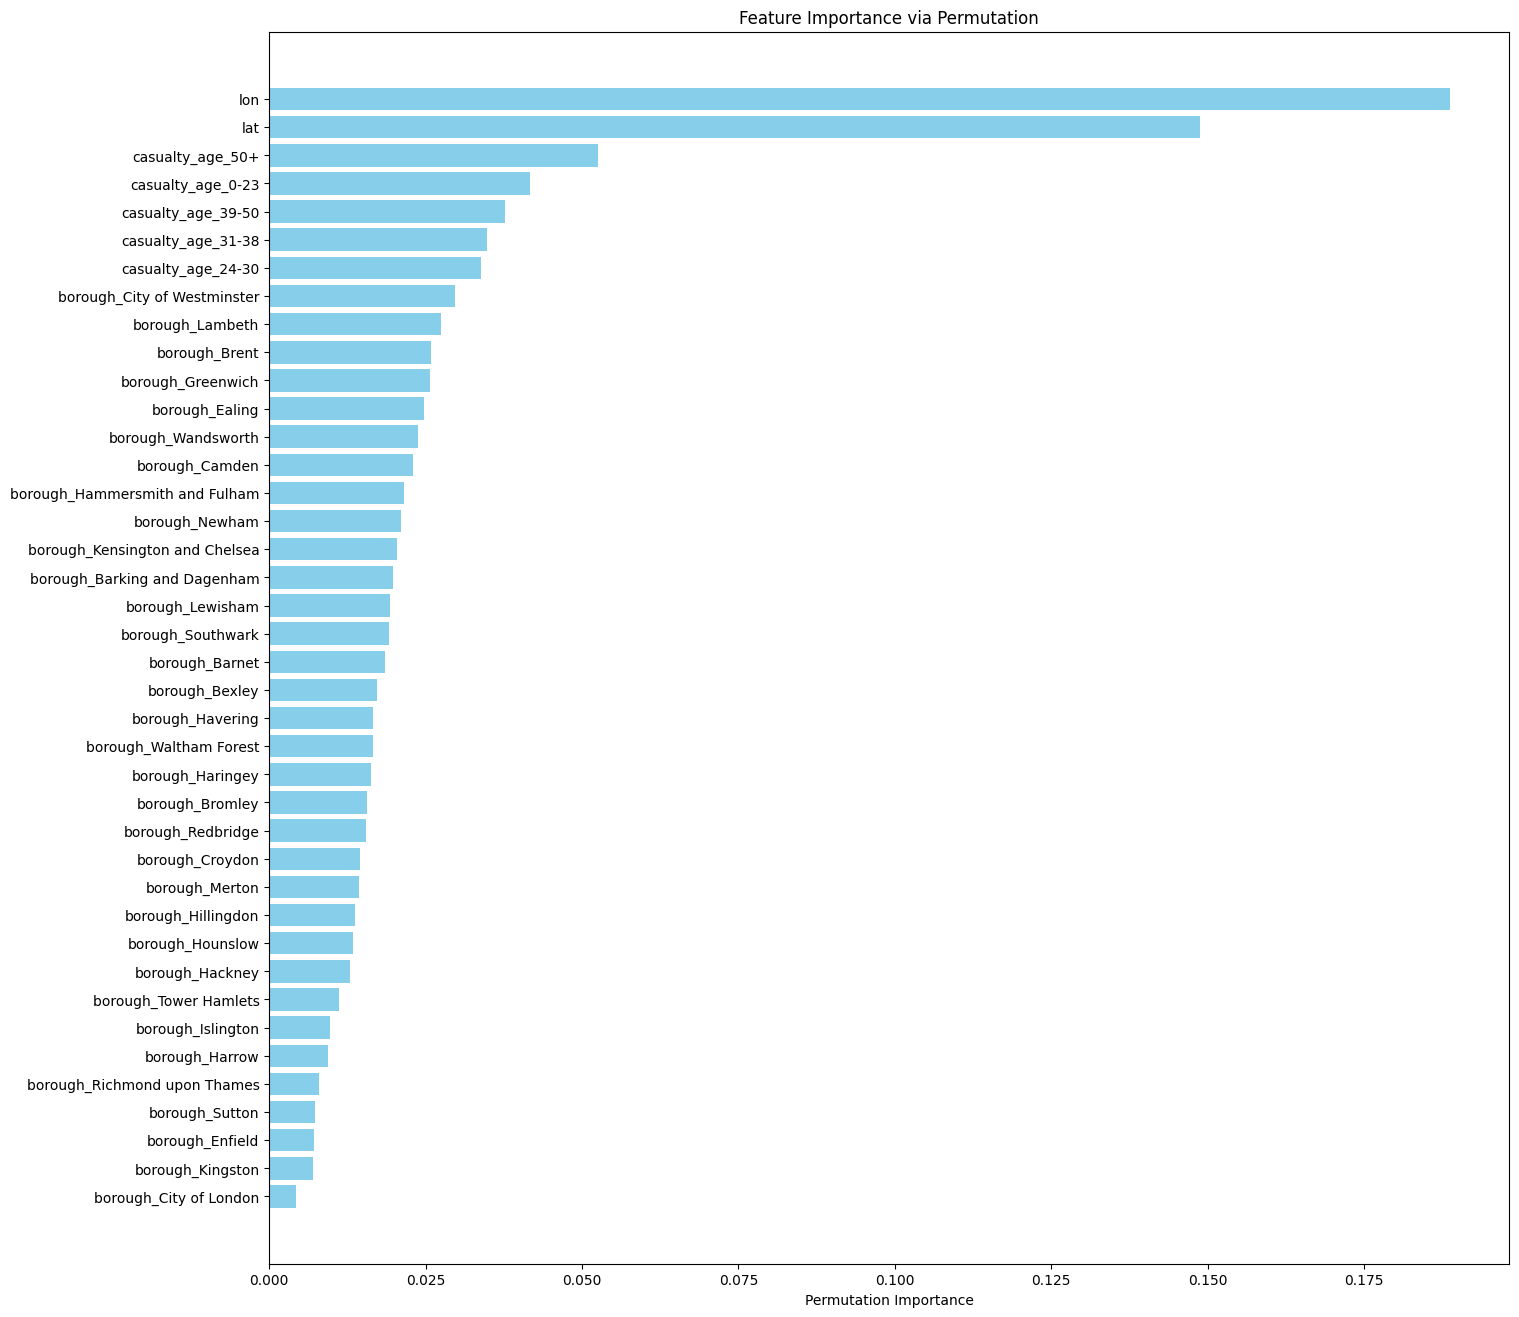

In [16]:
sorted_idx = r_train.importances_mean.argsort()

plt.figure(figsize=(16, 16))
plt.barh(X_train.columns[sorted_idx], r_train.importances_mean[sorted_idx], color="skyblue")
plt.xlabel("Permutation Importance")
plt.title("Feature Importance via Permutation")
plt.show()

In [17]:
print(df['severity'].value_counts())


severity
0    43060
1     7326
2      240
Name: count, dtype: int64


# Function Analysis

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score
)
from sklearn.utils.class_weight import compute_sample_weight
from imblearn.over_sampling import ADASYN

from xgboost import XGBClassifier

from sklearn.inspection import permutation_importance

def analyze_balancing_approaches(
    df,
    approach="none",        
    shuffle_data=True,    
    param_grid=None,       
    random_state=42
):
   
    if 'severity' not in df.columns:
        raise ValueError("The DataFrame must contain a 'severity' column as the target.")

    if param_grid is None:
        param_grid = {
            'learning_rate': [0.2, 0.3],
            'max_depth': [9, 11],
            'subsample': [0.8, 1.0],  
            # 'colsample_bytree': [0.6, 0.8, 1.0],
            # 'n_estimators': [100, 200, 300],
            # 'gamma': [0, 0.1, 0.2],
            # 'reg_alpha': [0.0, 0.1, 1.0],
            # 'reg_lambda': [1.0, 1.5, 2.0],
        }


    X = df.drop(columns=['severity', 'id', 'date'])
    y = df['severity']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,         
        shuffle=shuffle_data,
        random_state=random_state
    )


    if approach == "none":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
        X_test_res, y_test_res   = X_test.copy(), y_test.copy()

    elif approach == "entire":
        adasyn_entire = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_entire.fit_resample(X_train, y_train)

        adasyn_entire_test = ADASYN(random_state=random_state + 1)
        X_test_res, y_test_res = adasyn_entire_test.fit_resample(X_test, y_test)

    elif approach == "train_only":
        adasyn_train = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_train.fit_resample(X_train, y_train)

        X_test_res, y_test_res = X_test.copy(), y_test.copy()

    elif approach == "test_only":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()

        adasyn_test = ADASYN(random_state=random_state)
        X_test_res, y_test_res = adasyn_test.fit_resample(X_test, y_test)

    else:
        raise ValueError(
            "approach must be one of ['none', 'entire', 'train_only', 'test_only']"
        )


    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_res)

    xgb_model = XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(y)), 
        eval_metric='mlogloss',
        random_state=random_state,
        n_jobs=-1
    )

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='f1_macro', 
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)
    model = grid_search.best_estimator_

    print("\n===== Grid Search Results =====")
    print("Best Parameters:", grid_search.best_params_)
    print("Best F1 (CV):", grid_search.best_score_)

    y_pred = model.predict(X_test_res)

    print("\n===== Classification Report (Test) =====")
    print(classification_report(
        y_test_res, y_pred,
        target_names=['Slight', 'Serious', 'Fatal'],
        digits=3
    ))

    cm = confusion_matrix(y_test_res, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=['Slight', 'Serious', 'Fatal']
    )
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    y_proba = model.predict_proba(X_test_res)
    auc_test = roc_auc_score(y_test_res, y_proba, multi_class='ovr')
    print(f"\nAUC (Test) = {auc_test:.3f}")


    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(10, 8))
    plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], color="skyblue")
    plt.xlabel("Feature Importance (XGBoost built-in)")
    plt.title("Feature Importance by Gain")
    plt.tight_layout()
    plt.show()
    r_train = permutation_importance(
        model,
        X_train_res,
        y_train_res,
        n_repeats=30,
        random_state=random_state
    )

    perm_sorted_idx = r_train.importances_mean.argsort()

    plt.figure(figsize=(10, 8))
    plt.barh(X_train.columns[perm_sorted_idx],
             r_train.importances_mean[perm_sorted_idx],
             color="skyblue")
    plt.xlabel("Permutation Importance")
    plt.title("Feature Importance via Permutation")
    plt.tight_layout()
    plt.show()

    return model, grid_search


Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.7098138285410741

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.961     0.917     0.939      8613
     Serious      0.622     0.788     0.695      1465
       Fatal      0.800     0.750     0.774        48

    accuracy                          0.898     10126
   macro avg      0.794     0.819     0.803     10126
weighted avg      0.911     0.898     0.903     10126



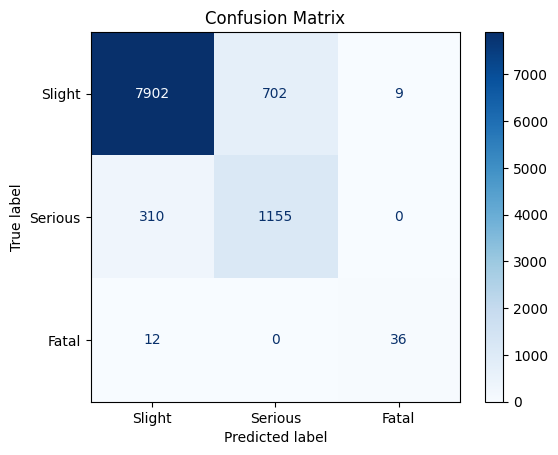


AUC (Test) = 0.892


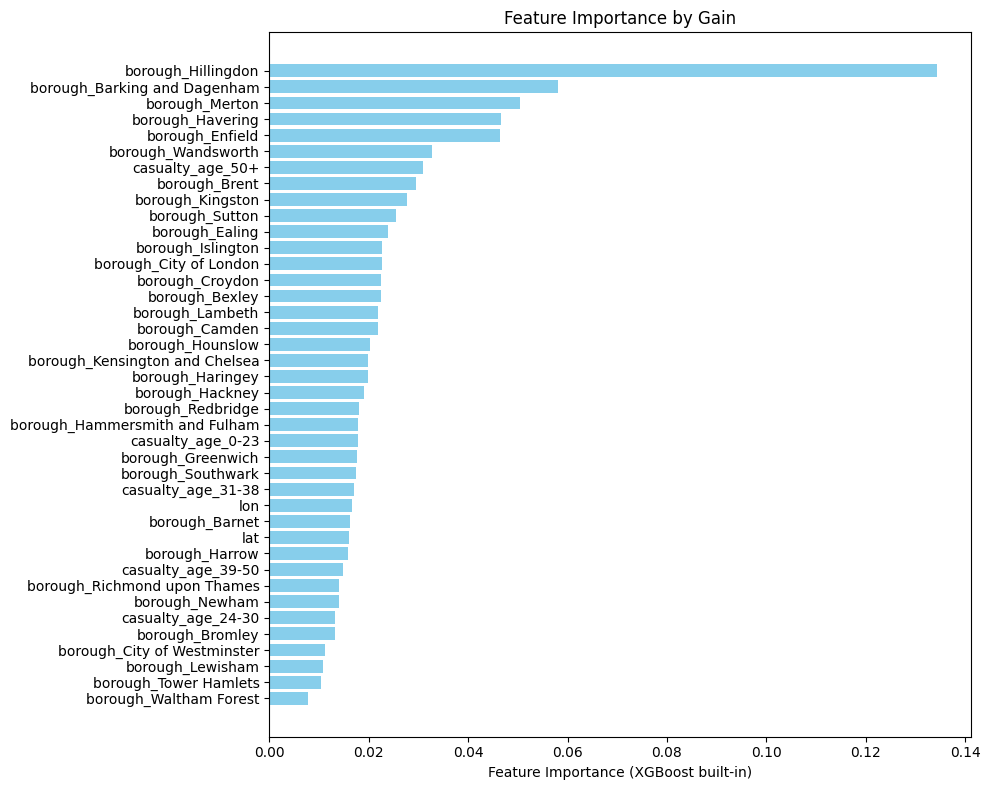

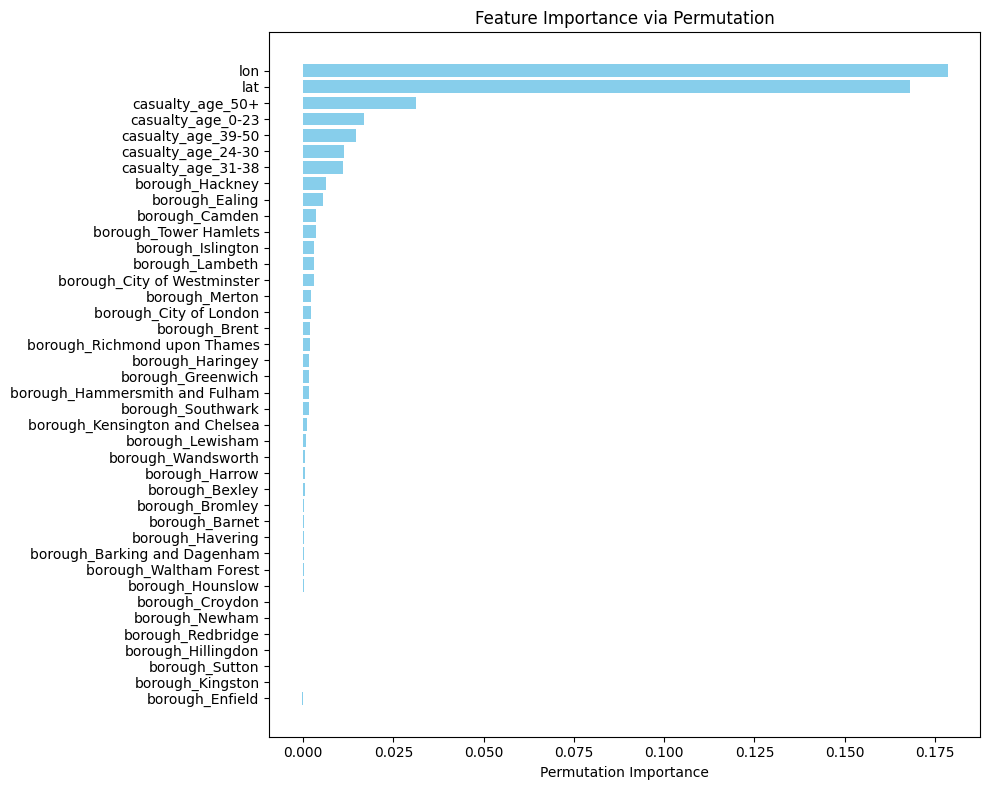

In [20]:
model_none, gs_none = analyze_balancing_approaches(df, approach="none")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.817696485422328

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.599     0.824     0.693      8613
     Serious      0.698     0.562     0.623      8862
       Fatal      0.928     0.766     0.839      8616

    accuracy                          0.716     26091
   macro avg      0.742     0.717     0.718     26091
weighted avg      0.741     0.716     0.718     26091



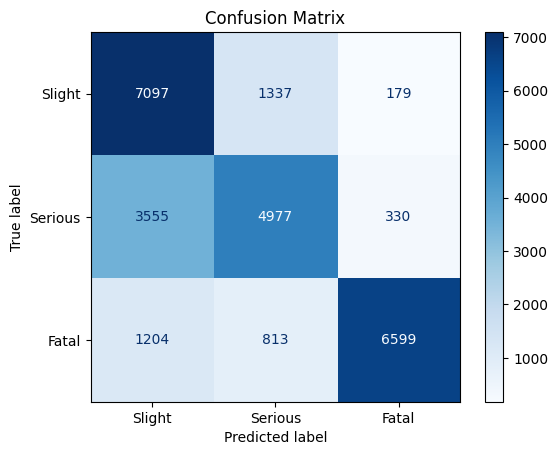


AUC (Test) = 0.884


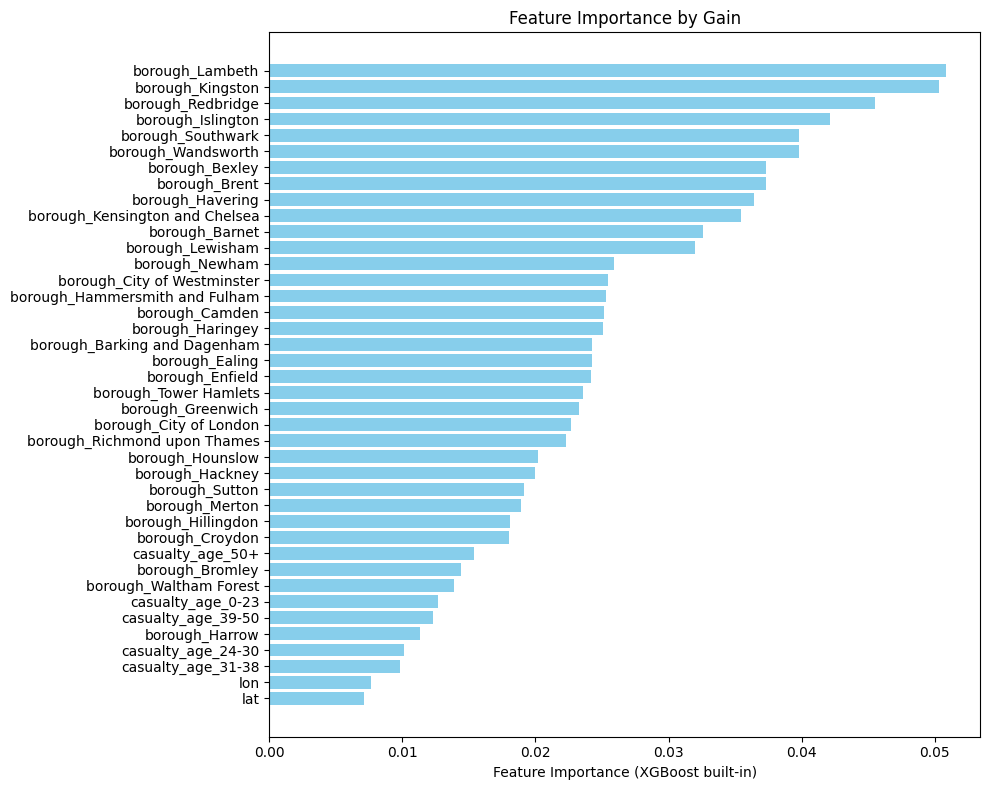

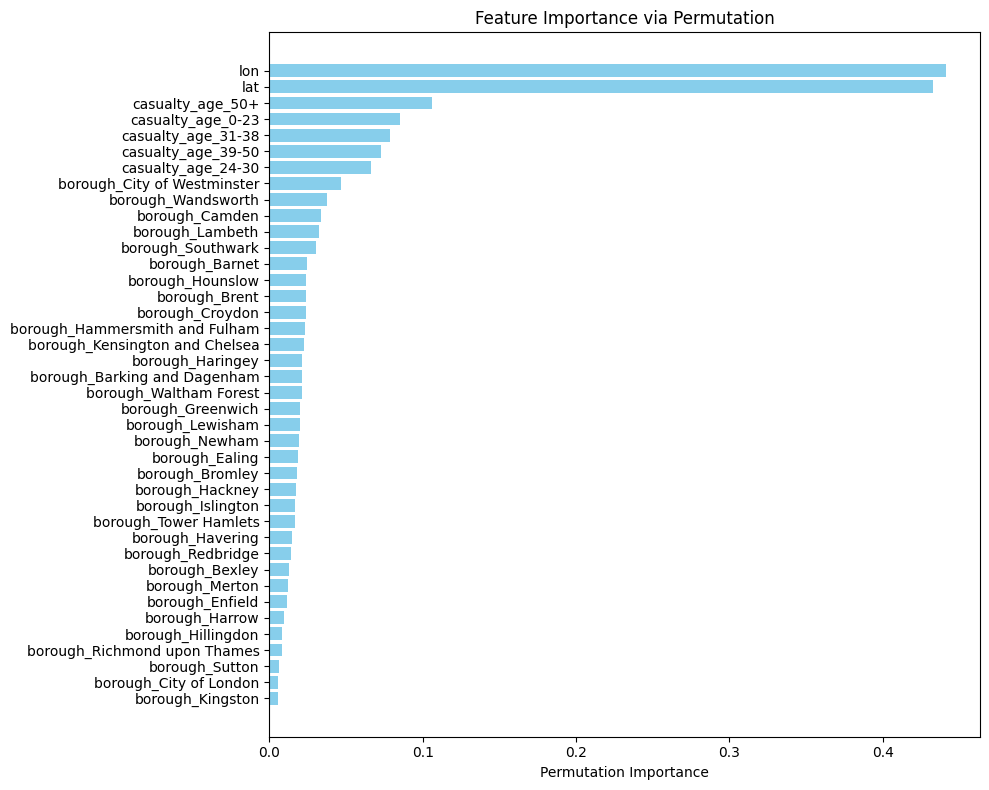

In [21]:
model_entire, gs_entire = analyze_balancing_approaches(df, approach="entire")

Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.817696485422328

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.948     0.824     0.882      8613
     Serious      0.442     0.729     0.550      1465
       Fatal      0.117     0.542     0.192        48

    accuracy                          0.809     10126
   macro avg      0.502     0.698     0.541     10126
weighted avg      0.871     0.809     0.830     10126



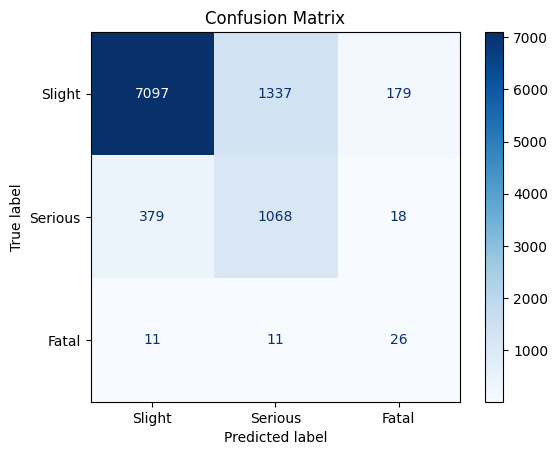


AUC (Test) = 0.851


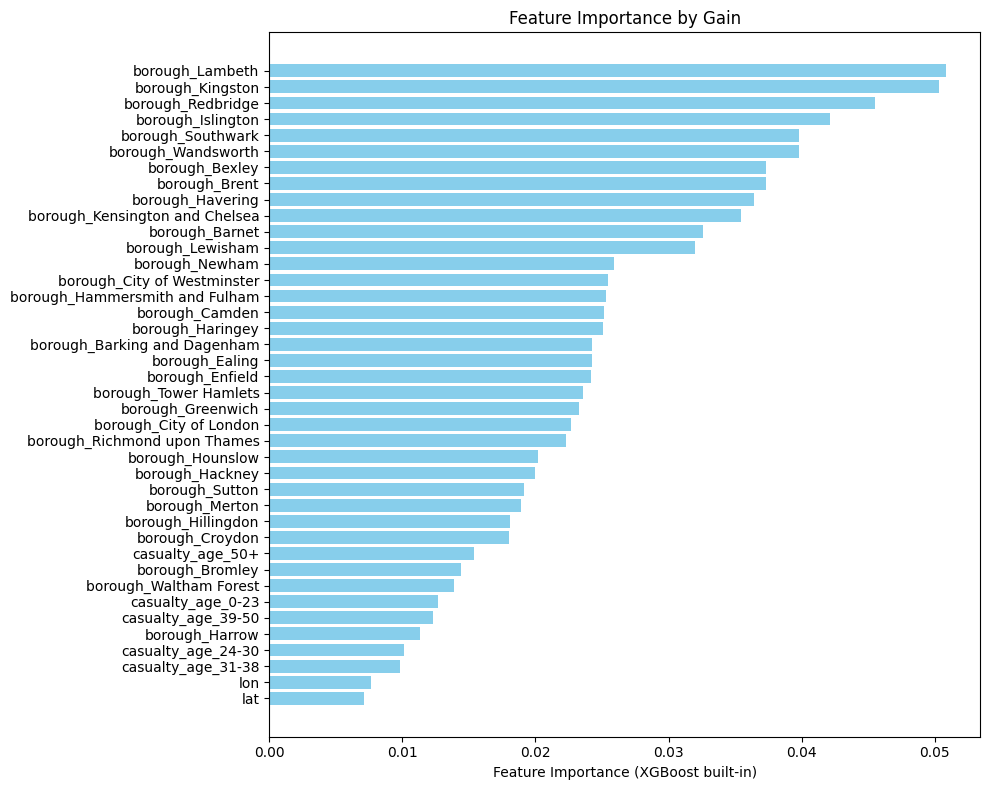

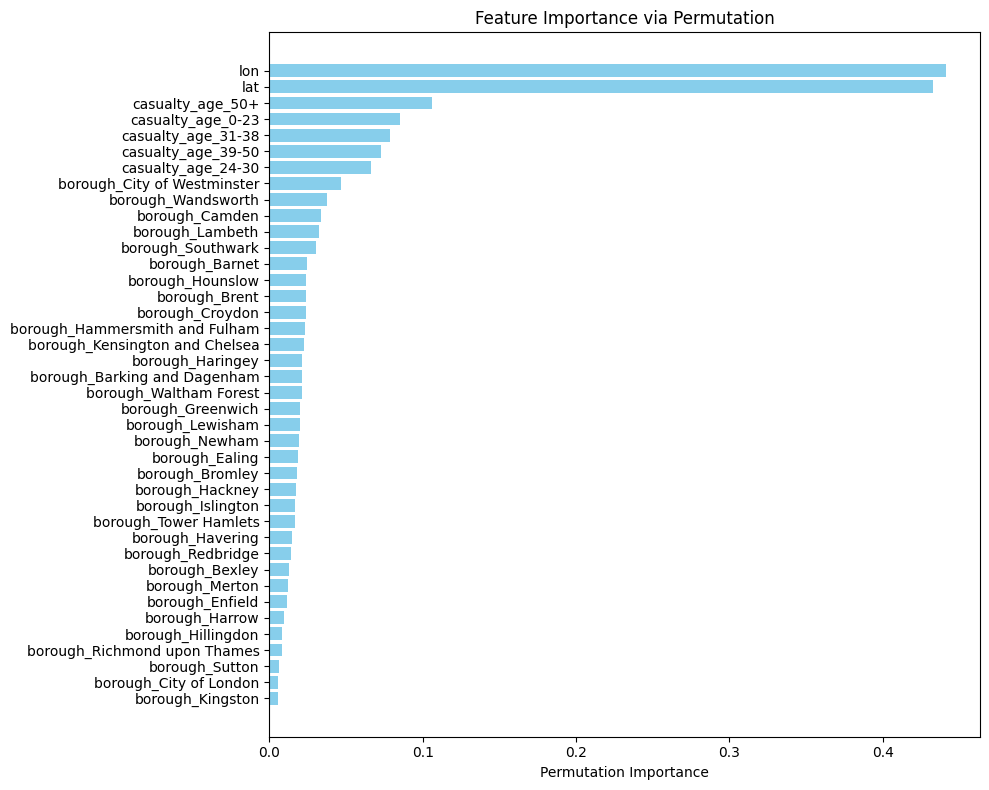

In [22]:
model_train, gs_train = analyze_balancing_approaches(df, approach="train_only")


In [ ]:

def analyze_features(
    df_merged,
    mode="borough",      
    approach="train_only",
    shuffle_data=True,
    param_grid=None,
    random_state=42
):
   

    if 'severity' not in df_merged.columns:
        raise ValueError("The DataFrame must contain 'severity' as the target.")

    df_copy = df_merged.copy()

    print("Removing cols based on selection: ", mode)
    borough_cols = [col for col in df_copy.columns if col.startswith('borough_')]
    if mode == "borough":
        drop_cols = ['lat', 'lon']
        for c in drop_cols:
            if c in df_copy.columns:
                df_copy.drop(columns=[c], inplace=True)
    elif mode == "lat_lon":
        df_copy.drop(columns=borough_cols, inplace=True, errors='ignore')
    elif mode == "all":
        pass
    else:
        raise ValueError("mode must be one of ['borough', 'lat_lon', 'all']")

    if param_grid is None:
        param_grid = {
            'learning_rate': [0.2, 0.3],
            'max_depth': [9, 11],
            'subsample': [0.8, 1.0],  
     
        }

    X = df_copy.drop(columns=['severity', 'id', 'date'])
    y = df_copy['severity']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        shuffle=shuffle_data,
        random_state=random_state
    )

    print("Setting train test splits based on approach: ", approach)
    if approach == "none":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()
        X_test_res, y_test_res   = X_test.copy(), y_test.copy()

    elif approach == "entire":
        adasyn_entire = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_entire.fit_resample(X_train, y_train)

        adasyn_entire_test = ADASYN(random_state=random_state + 1)
        X_test_res, y_test_res = adasyn_entire_test.fit_resample(X_test, y_test)

    elif approach == "train_only":
        adasyn_train = ADASYN(random_state=random_state)
        X_train_res, y_train_res = adasyn_train.fit_resample(X_train, y_train)

        X_test_res, y_test_res = X_test.copy(), y_test.copy()

    elif approach == "test_only":
        X_train_res, y_train_res = X_train.copy(), y_train.copy()

        adasyn_test = ADASYN(random_state=random_state)
        X_test_res, y_test_res = adasyn_test.fit_resample(X_test, y_test)

    else:
        raise ValueError("approach must be one of ['none','entire','train_only','test_only']")

    sample_weights = compute_sample_weight(class_weight='balanced', y=y_train_res)

    xgb_model = XGBClassifier(
        objective='multi:softprob',
        num_class=len(np.unique(y)), 
        eval_metric='mlogloss',
        random_state=random_state,
        n_jobs=-1
    )
    print("Initiating Grid Search")
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='f1_macro',
        cv=3,
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_res, y_train_res, sample_weight=sample_weights)
    model = grid_search.best_estimator_

    print("\n===== Grid Search Results =====")
    print("Best Parameters:", grid_search.best_params_)
    print("Best F1 (CV):", grid_search.best_score_)

    y_pred = model.predict(X_test_res)

    print("\n===== Classification Report (Test) =====")
    print(classification_report(
        y_test_res, y_pred,
        target_names=['Slight', 'Serious', 'Fatal'],
        digits=3
    ))

    cm = confusion_matrix(y_test_res, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=['Slight','Serious','Fatal'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f"Confusion Matrix: {mode} | {approach}")
    plt.show()

    y_proba = model.predict_proba(X_test_res)
    auc_test = roc_auc_score(y_test_res, y_proba, multi_class='ovr')
    print(f"\nAUC (Test) = {auc_test:.3f}")

    feature_importance = model.feature_importances_
    sorted_idx = np.argsort(feature_importance)

    plt.figure(figsize=(8, 6))
    plt.barh(X_train.columns[sorted_idx], feature_importance[sorted_idx], color="skyblue")
    plt.xlabel("Feature Importance (XGBoost built-in)")
    plt.title(f"Feature Importance by Gain ({mode} | {approach})")
    plt.tight_layout()
    plt.show()

    r_train = permutation_importance(
        model,
        X_train_res,
        y_train_res,
        n_repeats=30,
        random_state=random_state
    )
    perm_sorted_idx = r_train.importances_mean.argsort()

    plt.figure(figsize=(8, 6))
    plt.barh(X_train.columns[perm_sorted_idx],
             r_train.importances_mean[perm_sorted_idx],
             color="skyblue")
    plt.xlabel("Permutation Importance")
    plt.title(f"Permutation Importance ({mode} | {approach})")
    plt.tight_layout()
    plt.show()

    return model, grid_search


Borough columns only, resample train only (common approach)

Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 1.0}
Best F1 (CV): 0.6084242948291979

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.878     0.473     0.615      8613
     Serious      0.168     0.491     0.251      1465
       Fatal      0.009     0.229     0.017        48

    accuracy                          0.474     10126
   macro avg      0.352     0.398     0.294     10126
weighted avg      0.771     0.474     0.559     10126



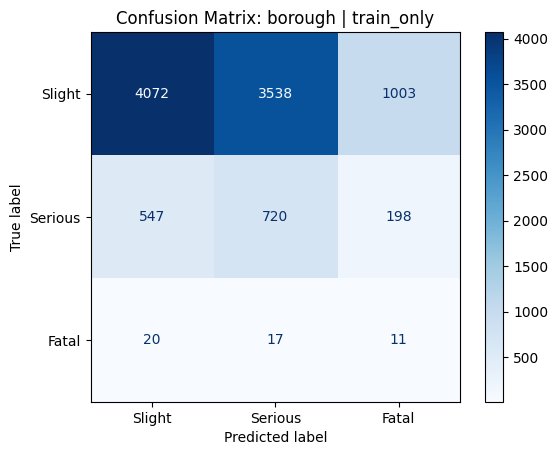


AUC (Test) = 0.581


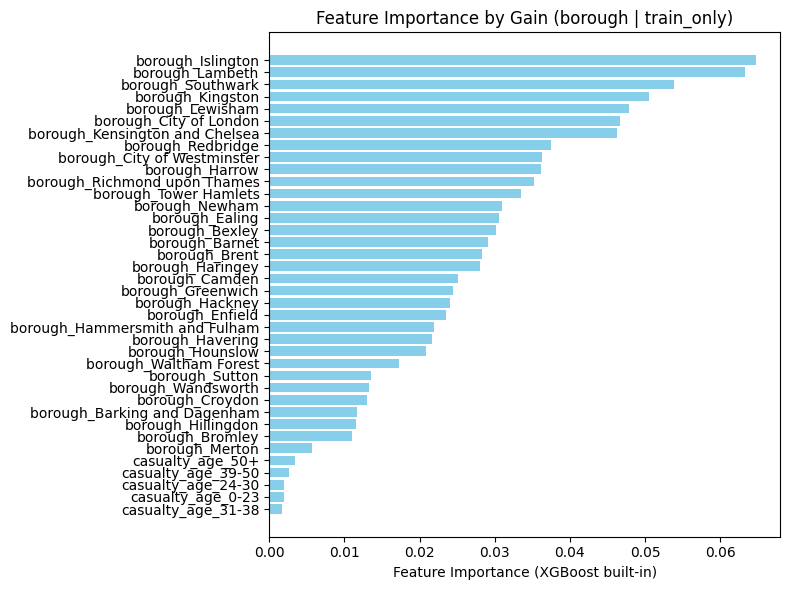

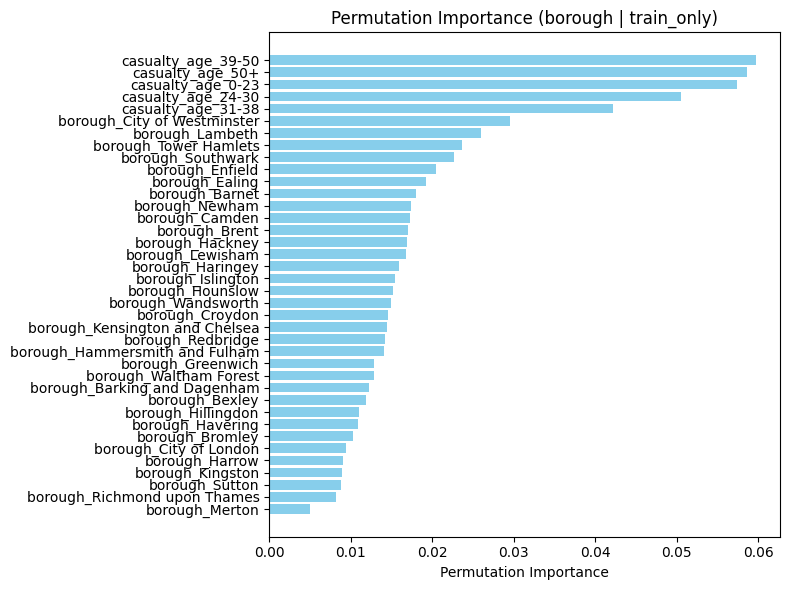

In [24]:
model_borough_train, gs_borough_train = analyze_features(
    df, 
    mode="borough", 
    approach="train_only"
)

Lat/Lon only, resample train only

Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Grid Search Results =====
Best Parameters: {'learning_rate': 0.3, 'max_depth': 11, 'subsample': 0.8}
Best F1 (CV): 0.7515507500330894

===== Classification Report (Test) =====
              precision    recall  f1-score   support

      Slight      0.946     0.791     0.862      8613
     Serious      0.447     0.697     0.545      1465
       Fatal      0.055     0.729     0.101        48

    accuracy                          0.777     10126
   macro avg      0.483     0.739     0.503     10126
weighted avg      0.870     0.777     0.812     10126



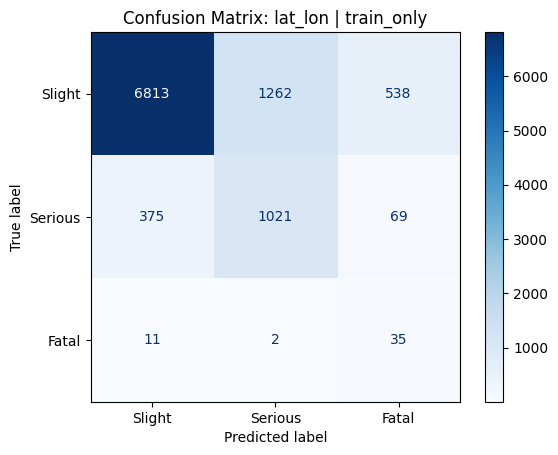


AUC (Test) = 0.852


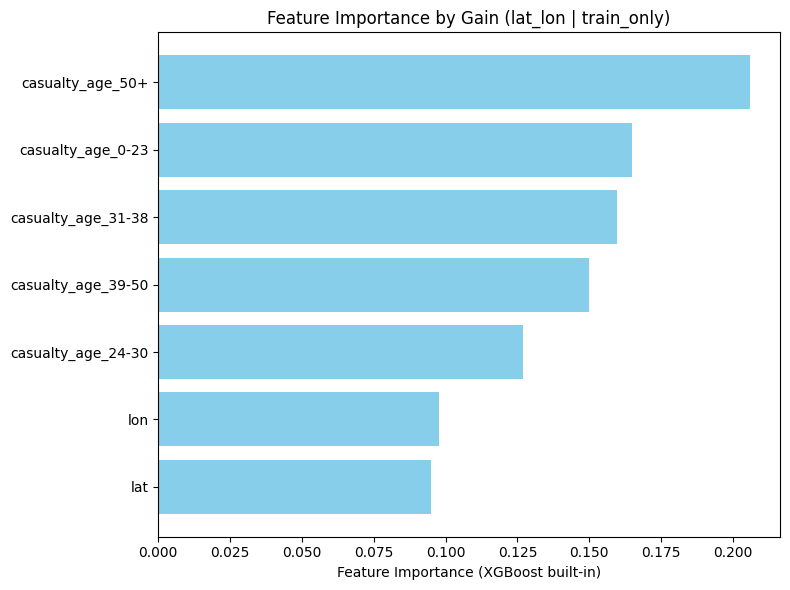

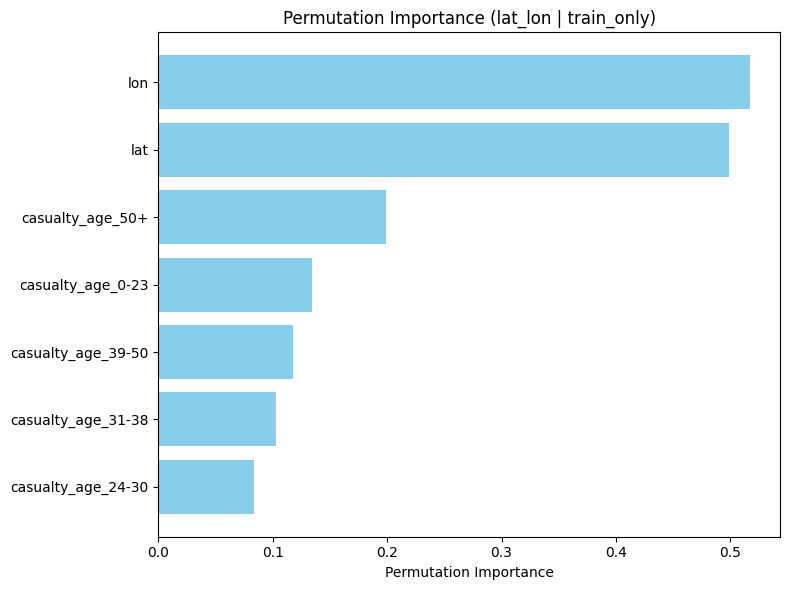

In [25]:
model_latlon_train, gs_latlon_train = analyze_features(
    df, 
    mode="lat_lon", 
    approach="train_only"
)

CHAT GPT SUMMARY OF RESULTS LOL
F1-score:
borough: 0.608 (poorer overall classification)
lat_lon: 0.751 (significantly better at balancing precision and recall)
AUC-score:
borough: 0.581 (barely better than random guessing!)
lat_lon: 0.852 (much stronger classification ability)
Accuracy:
borough: 0.474 (almost as bad as random guessing)
lat_lon: 0.777 (more reliable predictions)
Conclusion: lat_lon features (latitude & longitude) contribute more to predicting severity than borough features.